In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 40

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 10

# Other
DEVICE = "cuda"
GRAYSCALE = False

In [3]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [4]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [5]:
from torch.utils import data

from torchvision import transforms
from torchvision.datasets import MNIST

class BiasedMNIST(MNIST):
    """A base class for Biased-MNIST.
    We manually select ten colours to synthetic colour bias. (See `COLOUR_MAP` for the colour configuration)
    Usage is exactly same as torchvision MNIST dataset class.

    You have two paramters to control the level of bias.

    Parameters
    ----------
    root : str
        path to MNIST dataset.
    data_label_correlation : float, default=1.0
        Here, each class has the pre-defined colour (bias).
        data_label_correlation, or `rho` controls the level of the dataset bias.

        A sample is coloured with
            - the pre-defined colour with probability `rho`,
            - coloured with one of the other colours with probability `1 - rho`.
              The number of ``other colours'' is controlled by `n_confusing_labels` (default: 9).
        Note that the colour is injected into the background of the image (see `_binary_to_colour`).

        Hence, we have
            - Perfectly biased dataset with rho=1.0
            - Perfectly unbiased with rho=0.1 (1/10) ==> our ``unbiased'' setting in the test time.
        In the paper, we explore the high correlations but with small hints, e.g., rho=0.999.

    n_confusing_labels : int, default=9
        In the real-world cases, biases are not equally distributed, but highly unbalanced.
        We mimic the unbalanced biases by changing the number of confusing colours for each class.
        In the paper, we use n_confusing_labels=9, i.e., during training, the model can observe
        all colours for each class. However, you can make the problem harder by setting smaller n_confusing_labels, e.g., 2.
        We suggest to researchers considering this benchmark for future researches.
    """

    COLOUR_MAP = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [225, 225, 0], [225, 0, 225],
                  [0, 255, 255], [255, 128, 0], [255, 0, 128], [128, 0, 255], [128, 128, 128]]

    def __init__(self, root, train=True, transform=None, target_transform=None,
                 download=False, data_label_correlation=1.0, n_confusing_labels=9):
        super().__init__(root, train=train, transform=transform,
                         target_transform=target_transform,
                         download=download)
        self.random = True

        self.data_label_correlation = data_label_correlation
        self.n_confusing_labels = n_confusing_labels
        self.data, self.targets, self.colored_bg, self.biased_targets = self.build_biased_mnist()

        indices = np.arange(len(self.data))
        self._shuffle(indices)

        self.data = self.data[indices].numpy()
        self.colored_bg = self.colored_bg[indices].numpy()
        self.targets = self.targets[indices]
        self.biased_targets = self.biased_targets[indices]

    @property
    def raw_folder(self):
        return os.path.join(self.root, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, 'processed')

    def _shuffle(self, iteratable):
        if self.random:
            np.random.shuffle(iteratable)

    def _make_biased_mnist(self, indices, label):
        raise NotImplementedError

    def _update_bias_indices(self, bias_indices, label):
        if self.n_confusing_labels > 9 or self.n_confusing_labels < 1:
            raise ValueError(self.n_confusing_labels)

        indices = np.where((self.targets == label).numpy())[0]
        self._shuffle(indices)
        indices = torch.LongTensor(indices)

        n_samples = len(indices)
        n_correlated_samples = int(n_samples * self.data_label_correlation)
        n_decorrelated_per_class = int(np.ceil((n_samples - n_correlated_samples) / (self.n_confusing_labels)))

        correlated_indices = indices[:n_correlated_samples]
        bias_indices[label] = torch.cat([bias_indices[label], correlated_indices])

        decorrelated_indices = torch.split(indices[n_correlated_samples:], n_decorrelated_per_class)

        other_labels = [_label % 10 for _label in range(label + 1, label + 1 + self.n_confusing_labels)]
        self._shuffle(other_labels)

        for idx, _indices in enumerate(decorrelated_indices):
            _label = other_labels[idx]
            bias_indices[_label] = torch.cat([bias_indices[_label], _indices])

    def build_biased_mnist(self):
        """Build biased MNIST.
        """
        n_labels = self.targets.max().item() + 1

        bias_indices = {label: torch.LongTensor() for label in range(n_labels)}
        for label in range(n_labels):
            self._update_bias_indices(bias_indices, label)

        data = torch.ByteTensor()
        targets = torch.LongTensor()
        colored_bg = torch.ByteTensor()
        biased_targets = []

        for bias_label, indices in bias_indices.items():
            (_data, _colored_bg), _targets = self._make_biased_mnist(indices, bias_label)
            data = torch.cat([data, _data])
            colored_bg = torch.cat([colored_bg, _colored_bg])
            targets = torch.cat([targets, _targets])
            biased_targets.extend([bias_label] * len(indices))

        biased_targets = torch.LongTensor(biased_targets)
        return data, targets, colored_bg, biased_targets

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        colored_bg = self.colored_bg[index]
        img = Image.fromarray(img.astype(np.uint8), mode='RGB')
        bias = Image.fromarray(colored_bg.astype(np.uint8), mode='RGB')

        if self.transform is not None:
            img = self.transform(img)
            bias = self.transform(bias)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        img = np.asarray(img)
        bias = np.asarray(bias)
        
        label = torch.zeros(10)
        label.scatter_(0, target, 1)
        
        return img, target, bias, int(self.biased_targets[index])
#         return img, label, bias, int(self.biased_targets[index])


class ColourBiasedMNIST(BiasedMNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None,
                 download=False, data_label_correlation=1.0, n_confusing_labels=9):
        super(ColourBiasedMNIST, self).__init__(root, train=train, transform=transform,
                                                target_transform=target_transform,
                                                download=download,
                                                data_label_correlation=data_label_correlation,
                                                n_confusing_labels=n_confusing_labels)

    def _binary_to_colour(self, data, colour):
        fg_data = torch.zeros_like(data)
        fg_data[data != 0] = 255
        fg_data[data == 0] = 0
        fg_data = torch.stack([fg_data, fg_data, fg_data], dim=1)

        bg_data = torch.zeros_like(data)
        bg_data[data == 0] = 1
        bg_data[data != 0] = 0
        bg_data = torch.stack([bg_data, bg_data, bg_data], dim=3)
        bg_data = bg_data * torch.ByteTensor(colour)
        
        
        colored_bg = (bg_data + 1 - bg_data) * torch.ByteTensor(colour)
        
        bg_data = bg_data.permute(0, 3, 1, 2)
        data = fg_data + bg_data
        
        return data.permute(0, 2, 3, 1), colored_bg

    def _make_biased_mnist(self, indices, label):
        return self._binary_to_colour(self.data[indices], self.COLOUR_MAP[label]), self.targets[indices]


def get_biased_mnist_dataloader(root, batch_size, data_label_correlation,
                                n_confusing_labels=9, train=True, num_workers=4):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5),
                             std=(0.5, 0.5, 0.5))])
    dataset = ColourBiasedMNIST(root, train=train, transform=transform,
                                download=True, data_label_correlation=data_label_correlation,
                                n_confusing_labels=n_confusing_labels)
    dataloader = data.DataLoader(dataset=dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=num_workers,
                                 pin_memory=True)
    return dataloader

In [6]:
cmnist_train = get_biased_mnist_dataloader(root='data',
                                           batch_size=128, 
                                           data_label_correlation=0.999,
                                          n_confusing_labels=9,
                                          train=True)
cmnist_val_bias = get_biased_mnist_dataloader(root='data',
                                           batch_size=128, 
                                           data_label_correlation=0.999,
                                          n_confusing_labels=9,
                                          train=False)
cmnist_val_unbias = get_biased_mnist_dataloader(root='data',
                                           batch_size=128, 
                                           data_label_correlation=0.1,
                                          n_confusing_labels=9,
                                          train=False)
cmnist_val_origin = get_biased_mnist_dataloader(root='data',
                                           batch_size=128, 
                                           data_label_correlation=0,
                                          n_confusing_labels=9,
                                          train=False)

In [7]:
for batch_idx, (features, targets, bias, bias_label) in enumerate(cmnist_train):

    features = features
    targets = targets
    break

In [8]:
##########################
### MODEL
##########################


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        post_gap_feats = torch.flatten(x, 1)
        
        x = x.view(x.size(0), -1)
        
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, post_gap_feats



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [9]:
class SimpleConvNet(nn.Module):
    def __init__(self, num_classes=10, kernel_size=7, feature_pos='post'):
        super(SimpleConvNet, self).__init__()
        padding = kernel_size // 2
        layers = [ 
            nn.Conv2d(3, 16, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        ]
        self.extracter = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 10)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if feature_pos not in ['pre', 'post', 'logits']:
            raise ValueError(feature_pos)

        self.feature_pos = feature_pos

    def forward(self, x, logits_only=False):
        pre_gap_feats = self.extracter(x)
        post_gap_feats = self.avgpool(pre_gap_feats)
        post_gap_feats = torch.flatten(post_gap_feats, 1)
        logits = self.fc(post_gap_feats)

        if logits_only:
            return logits

        elif self.feature_pos == 'pre':
            feats = pre_gap_feats
        elif self.feature_pos == 'post':
            feats = post_gap_feats
        else:
            feats = logits
        return logits, feats

In [10]:
torch.manual_seed(RANDOM_SEED)
from criterions import get_criterion
from criterions.sigma_utils import median_distance, feature_dimension

# f_net = resnet18(NUM_CLASSES).to(DEVICE)
f_net = SimpleConvNet(kernel_size=7, feature_pos='post').to(DEVICE)
g_net = SimpleConvNet(kernel_size=1, feature_pos='post').to(DEVICE)
# g_net = resnet18(NUM_CLASSES).to(DEVICE)

f_optimizer = torch.optim.Adam([{'params': f_net.parameters()}], lr=LEARNING_RATE)  
g_optimizer = torch.optim.Adam([{'params': g_net.parameters()}], lr=LEARNING_RATE)  

# criterion config
outer_criterion='RbfHSIC'
inner_criterion='MinusRbfHSIC'
rbf_sigma_scale_x=1
rbf_sigma_scale_y=1
rbf_sigma_x=1
rbf_sigma_y=1
update_sigma_per_epoch=False
hsic_alg='unbiased'


outer_criterion_config={'sigma_x': rbf_sigma_x, 'sigma_y': rbf_sigma_y,
                        'algorithm': hsic_alg}
outer_criterion_detail={'sigma_x_type': rbf_sigma_x,
                        'sigma_y_type': rbf_sigma_y,
                        'sigma_x_scale': rbf_sigma_scale_x,
                        'sigma_y_scale': rbf_sigma_scale_y}
inner_criterion_config={'sigma_x': rbf_sigma_x, 'sigma_y': rbf_sigma_y,
                        'algorithm': hsic_alg}
inner_criterion_detail={'sigma_x_type': rbf_sigma_x,
                        'sigma_y_type': rbf_sigma_y,
                        'sigma_x_scale': rbf_sigma_scale_x,
                        'sigma_y_scale': rbf_sigma_scale_y}

outer_criterion = get_criterion(outer_criterion)(**outer_criterion_config)
inner_criterion = get_criterion(inner_criterion)(**inner_criterion_config)
classification_criterion = nn.CrossEntropyLoss()


In [11]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets, bias, _) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)
#         targets = torch.argmax(targets, 1).to(device)
        bias = bias.to(device)

        logits, probas = model(features)
#         logits, probas = model(bias)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [12]:
####Training#######
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    f_net.train()
    g_net.train()
    for batch_idx, (features, targets, biases, _) in enumerate(cmnist_train):
        
        features = features.to(DEVICE).requires_grad_()
        labels = targets.to(DEVICE)
        biases = biases.to(DEVICE).requires_grad_()
            
        ## FORWARD AND BACK PROP
        
        ## g_net update
        g_preds, g_feats = g_net(features)
        g_loss = 0
        
        ##g_net classification
        g_loss_cls = classification_criterion(g_preds, labels)
        g_loss += g_loss_cls
        
        ##g_net inner loop
        f_preds, f_feats = f_net(features)
        g_loss_inner = inner_criterion(g_feats, f_feats, labels=labels)
        g_loss += g_loss_inner
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        
        ##f_net update
        f_preds, f_feats = f_net(features)
        f_loss = 0
        f_loss_cls = classification_criterion(f_preds, labels)
        f_loss += f_loss_cls
        
        ##f_net outer loop
        f_loss_indep = 0
        _g_preds, _g_feats = g_net(features)
        _f_loss_indep = outer_criterion(f_feats, _g_feats, labels=labels, f_pred=f_preds)
        f_loss_indep += _f_loss_indep
        
        f_loss += f_loss_indep
        
        f_optimizer.zero_grad()
        f_loss.backward()
        f_optimizer.step()
        
    
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(cmnist_train), f_loss))

    f_net.eval()
    g_net.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(f_net, cmnist_val_unbias, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/040 | Batch 0000/0469 | Cost: 2.3749
Epoch: 001/040 | Batch 0050/0469 | Cost: 0.0920
Epoch: 001/040 | Batch 0100/0469 | Cost: 0.1859
Epoch: 001/040 | Batch 0150/0469 | Cost: 0.0553
Epoch: 001/040 | Batch 0200/0469 | Cost: 0.0440
Epoch: 001/040 | Batch 0250/0469 | Cost: 0.0378
Epoch: 001/040 | Batch 0300/0469 | Cost: 0.0350
Epoch: 001/040 | Batch 0350/0469 | Cost: 0.0259
Epoch: 001/040 | Batch 0400/0469 | Cost: 0.0653
Epoch: 001/040 | Batch 0450/0469 | Cost: 0.0220
Epoch: 001/040 | Train: 9.960%
Time elapsed: 0.56 min
Epoch: 002/040 | Batch 0000/0469 | Cost: 0.0229
Epoch: 002/040 | Batch 0050/0469 | Cost: 0.0246
Epoch: 002/040 | Batch 0100/0469 | Cost: 0.0160
Epoch: 002/040 | Batch 0150/0469 | Cost: 0.0179
Epoch: 002/040 | Batch 0200/0469 | Cost: 0.0191
Epoch: 002/040 | Batch 0250/0469 | Cost: 0.1059
Epoch: 002/040 | Batch 0300/0469 | Cost: 0.0606
Epoch: 002/040 | Batch 0350/0469 | Cost: 0.0125
Epoch: 002/040 | Batch 0400/0469 | Cost: 0.0104
Epoch: 002/040 | Batch 0450/0469 |

In [13]:
####Test####
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(f_net, cmnist_val_unbias, device=DEVICE)))

Test accuracy: 35.40%


In [14]:
####Test####
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(f_net, cmnist_val_origin, device=DEVICE)))

Test accuracy: 28.20%


In [15]:
####Test####
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(f_net, cmnist_val_bias, device=DEVICE)))

Test accuracy: 99.88%


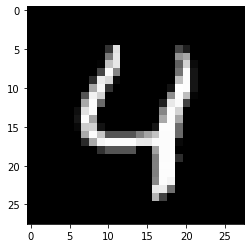

In [16]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

nhw_img = np.transpose(features[4].expand(3,28,28), axes=(1, 2, 0))
plt.imshow(nhw_img);


In [17]:
def compute_matrix(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    matrix_gt = np.zeros((10,10))
    matrix_bs = np.zeros((10,10))
    for i, (features, targets, bias, bias_label) in enumerate(data_loader):
        features = features.to(device)
#         targets = torch.argmax(targets, 1).to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(logits, 1)
        for i in range(targets.size(0)):
            matrix_gt[predicted_labels[i], targets[i]] += 1
            matrix_bs[predicted_labels[i], bias_label[i]] += 1
        num_examples += targets.size(0)
    return matrix_gt/num_examples *10, matrix_bs/num_examples *10

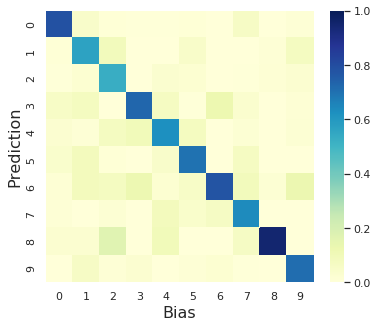

In [18]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
matrix_gt, matrix_bs = compute_matrix(f_net, cmnist_val_unbias, device=DEVICE)

plt.rcParams['figure.figsize'] = (6.0, 5.0)
ax = sns.heatmap(matrix_bs, cmap="YlGnBu", vmin=0., vmax=1.)
# ax.set_aspect("equal")
plt.xlabel("Bias", fontsize=16)
plt.ylabel("Prediction", fontsize=16)
fig =  ax.get_figure()
fig.savefig('matrix/rebias-bias.pdf')

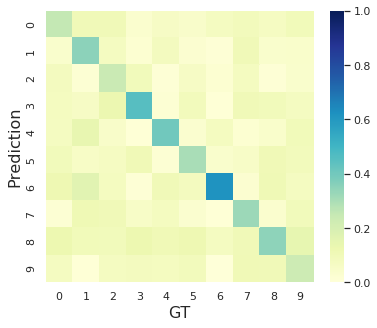

In [19]:
ax = sns.heatmap(matrix_gt, cmap="YlGnBu", vmin=0., vmax=1.)
plt.xlabel("GT", fontsize=16)
plt.ylabel("Prediction", fontsize=16)
fig =  ax.get_figure()
fig.savefig('matrix/rebias-gt.pdf')

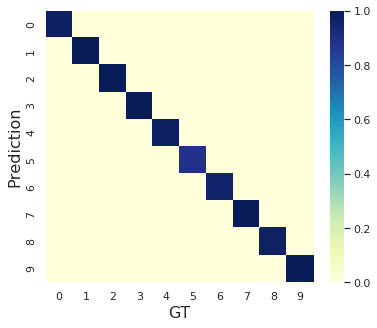

In [20]:
matrix_gt, matrix_bs = compute_matrix(f_net, cmnist_val_bias, device=DEVICE)
ax = sns.heatmap(matrix_gt, cmap="YlGnBu", vmin=0., vmax=1.)
plt.xlabel("GT", fontsize=16)
plt.ylabel("Prediction", fontsize=16)
fig =  ax.get_figure()
fig.savefig('matrix/rebias-999.pdf')

# 